**Table of contents**<a id='toc0_'></a>    
- [Обработка данных и Topic Modeling](#toc1_)    
  - [Импорт библиотек](#toc1_1_)    
  - [Профили](#toc1_2_)    
  - [Посты](#toc1_3_)    
  - [Реакции](#toc1_4_)    
  - [Обработка данных](#toc1_5_)    
  - [Лемманизация текста](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Обработка данных и Topic Modeling](#toc0_)

## <a id='toc1_1_'></a>[Импорт библиотек](#toc0_)

In [107]:
import pandas as pd
import numpy as np
import json
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from  pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [108]:
from ast import literal_eval

In [109]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [111]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Зададим random_state

In [112]:
SEED =42

## <a id='toc1_2_'></a>[Профили](#toc0_)

In [113]:
profiles_main = pd.read_json('total_profiles.json', orient='index')
print(profiles_main.shape)
profiles_main.head()

(199, 8)


,name,city,connections,role,company,experience,employment_type,skills
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,..."
kirill-gonin,Kirill Gonin,Russia,180,Full Stack Developer JavaScript,«Сервисный центр Транстелематика»,2.75,Full-time,"[React, Jest, Material-UI, Express, CSS, HTML,..."
alexey-sergienko,Alexey Sergienko,Moscow,168,Software Developer,OZON.ru,9.83,Full-time,"[Электроника, Git, Vue.js, HTML, electron , Re..."


In [114]:
profiles_add = pd.read_json('profiles_developer_kristina_86.json', orient='index')
print(profiles_add.shape)
profiles_add.head(3)

(86, 8)


,name,city,connections,role,company,experience,employment_type,skills
anastasiia-miagkikh-b118a2168,Anastasiia Miagkikh,St Petersburg,138,Frontend Developer,Северсталь-Инфоком,4.08,Full-time,"[Photoshop, JavaScript, Redux, Matlab, React]"
mirkadev,Vladimir Mironov,Mordovia,132,Middle NodeJS Developer (backend only),SimbirSoft,4.58,unknown,"[Socket.IO, Koa.js, JavaScript, PostgreSQL, Mo..."
elena-vidyakina-2b877990,Elena Vidyakina,Russia,61,Senior backend developer,Yandex Eats,12.50,unknown,"[Angular, .NET, Unit Testing, C#, PowerDesigne..."


In [115]:
profiles_senior = pd.read_json('profiles_developer_senior.json', orient='index')
print(profiles_senior.shape)
profiles_senior.head(3)

(86, 8)


,name,city,connections,role,company,experience,employment_type,skills
silvansky,Valentine Silvansky,Moscow,307,Senior Developer,Songsterr,15.83,unknown,"[JavaScript, Subversion, Carbon, Objective-C, ..."
vyacheslav-kruglov-2279421a5,Vyacheslav Kruglov,Russia,109,Senior Golang Developer,Yandex,4.50,Full-time,"[SQL, Golang , go, Git]"
denis-k-0a44327b,Denis K.,Moscow,500+,Senior Golang Developer,KASPERSKY LABS LIMITED,5.50,Full-time,"[docker, API Gateways, Google API, Hyperledger..."


Объединим датафреймы

In [116]:
profiles = pd.concat([profiles_main, profiles_add, profiles_senior])
print(profiles.shape)

(371, 8)


## <a id='toc1_3_'></a>[Посты](#toc0_)

In [117]:
posts_main = pd.read_json('total_posts.json', orient='index')
posts_main.head(3)

,0,1,2,3,4,5,6,7,8,9
nurlan-isbulaev-34bb211a3,"🔥 11 сервисов на базе ИИ ,которые помогут прок...",🔥 Если вы в поисках удаленной работы или допол...,Как Ваш профиль LinkedIn виден со стороны рекр...,"🎯 𝗦𝗤𝗟 𝗭𝗲𝗿𝗼 𝘁𝗼 𝗛𝗲𝗿𝗼 Notes 𝘄𝗶𝘁𝗵 𝗠𝗶𝗻𝗱𝗺𝗮𝗽 📚SQL, or...",Rest API and HTTP notes.A REST API (Representa...,Best ChatGPT Alternatives to finish hours of w...,Землетрясения напомнили кто мы Мы все маленьк...,С момента начала моей работы в компании Доброз...,None,None
maria-terenteva,None,None,None,None,None,None,None,None,None,None
руслан-гусейнов-091858186,None,None,None,None,None,None,None,None,None,None


In [118]:
posts_add = pd.read_json('posts_developer_kristina_86.json', orient='index')
posts_add.head(3)

,0,1,2,3,4,5,6,7,8,9
anastasiia-miagkikh-b118a2168,None,None,None,None,None,None,None,None,None,None
mirkadev,I've broken a new record for touch typing (onl...,None,None,None,None,None,None,None,None,None
elena-vidyakina-2b877990,None,None,None,None,None,None,None,None,None,None


In [119]:
posts_senior = pd.read_json('posts_developer_senior.json', orient='index')
posts_senior.head(3)

,0,1,2,3,4,5
silvansky,None,None,None,None,None,None
vyacheslav-kruglov-2279421a5,None,None,None,None,None,None
denis-k-0a44327b,None,None,None,None,None,None


Объединим датафреймы

In [120]:
posts = pd.concat([posts_main, posts_add, posts_senior])
print(posts.shape)

(371, 10)


## <a id='toc1_4_'></a>[Реакции](#toc0_)

In [121]:
reactions_main = pd.read_json('total_reactions.json', orient='index')
reactions_main.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
nurlan-isbulaev-34bb211a3,"🔥 11 сервисов на базе ИИ ,которые помогут прок...",#opentowork #recruiter Всем привет! Приступаю ...,🔥 Если вы в поисках удаленной работы или допол...,Буду благодарна за репосты и лайки:),Simple example ✌️Backend - APIs - Frontend 🔥 F...,My biggest problem :),#chatgpt,(Обычный профессионал - VS - АйТи профессионал),JavaScript Array Methods CheatSheet 📍This will...,"Клянусь, с сегоняшним наймом, создаётся впечат...",...,None,None,None,None,None,None,None,None,None,None
maria-terenteva,Me being a parent:,Всем привет!Активно ищу работу/стажировку/подр...,#it #humor #memes,Всем привет 👋Linkedln сообщество сейчас активн...,"Ok, Google, сливаю суть: #BardAI сейчас исполь...","Новые сотрудники, GameMod ищет вас 👀 Возвращаю...",Hi everyone - I am looking for a new role and ...,"❗ТОП-15 ❗ РЕСУРСОВ, КОТОРЫЕ МОГУТ ПОМОЧЬ НЕ ТО...",🍃 Specialize in MongoDB to build your applicat...,Life is not a fair game 🥺 That is exactly how ...,...,"The more you know, the more you know that you ...",Loving these AI generated pictures of the Coro...,Employers wants young candidates with deep exp...,When I interviewed someone and their laptop......,https://lnkd.in/guxNaeUc#Smart,https://lnkd.in/g-StFrjNSome lovely vintage in...,None,None,None,None
руслан-гусейнов-091858186,#humor #it,"Я #нанимаю. Знаете людей, которых это может за...",This story is about my path to IT.I had some t...,Напомню один из основополагающих принципов наш...,"А у вас как дела, цсс инженеры и хтмл архитект...","Здравствуйте, я в поиске новой карьерной возмо...",Mama I made it #google .... first day at work,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [122]:
reactions_add = pd.read_json('reactions_developer_kristina_86.json', orient='index')
reactions_add.head(3)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
anastasiia-miagkikh-b118a2168,Houdini ocean#oceanstorm #houdini,My new employee asked me one day for time off....,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
mirkadev,If you meet me you'll see that I'm fast. At ev...,It's my first day of a new jobWish me good luck 🍀,"Здравствуйте, я в поиске новой карьерной возмо...","Не прошло и двадцати с лишним лет, как OZON.ru...",I am extremely happy and grateful to say that ...,Всем привет! Мой крёстный сегодня был вынужден...,We're thrilled to be back on the streets of La...,"Today, we’re thrilled to announce the latest a...",Open source technology is a critical part of o...,Our self-driving car first started operating o...,...,None,None,None,None,None,None,None,None,None,None
elena-vidyakina-2b877990,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [123]:
reactions_senior = pd.read_json('reactions_developer_senior.json', orient='index')
reactions_senior.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
silvansky,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
vyacheslav-kruglov-2279421a5,Привет!Меня зовут Максим Говоров. Вот уже 10 л...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
denis-k-0a44327b,Today I started a new job at Apple!☁️,Do you agree?,Progress 👍,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Объединим датафреймы

In [124]:
reactions = pd.concat([reactions_main, reactions_add, reactions_senior])
print(reactions.shape)

(371, 30)


## Выгрузка отфильтрованных данных

In [125]:
developer_df = pd.read_json('developer_profiles.json')
developer_df.head(3)

,name,city,connections,role,company,experience,employment_type,skills,reactions,posts
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д...","[Me being a parent:, Всем привет!Активно ищу р...","[None, None, None, None, None, None, None, Non..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,...","[#humor #it, Я #нанимаю. Знаете людей, которых...","[None, None, None, None, None, None, None, Non..."


In [126]:
developer_df['all_posts'] = developer_df['reactions'] + developer_df['posts']
developer_df.head(3)

,name,city,connections,role,company,experience,employment_type,skills,reactions,posts,all_posts
nurlan-isbulaev-34bb211a3,Nurlan Isbulaev,Moscow,500+,Backend Developer,Доброзайм,3.92,Full-time,"[JSON, AutoCAD, PHP, Технология строительного ...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про...","[🔥 11 сервисов на базе ИИ ,которые помогут про..."
maria-terenteva,Maria Terenteva,Moscow,500+,Frontend Developer | Angular,"LLC ""ROBIN""",3.67,Full-time,"[Git, HTML, Отчетность, Ведение переговоров, Д...","[Me being a parent:, Всем привет!Активно ищу р...","[None, None, None, None, None, None, None, Non...","[Me being a parent:, Всем привет!Активно ищу р..."
руслан-гусейнов-091858186,Руслан Гусейнов,Russia,500+,Frontend Developer,OZON.ru,3.67,Full-time,"[Vuex, WebSockets, ООП, git, TypeScript, Gulp,...","[#humor #it, Я #нанимаю. Знаете людей, которых...","[None, None, None, None, None, None, None, Non...","[#humor #it, Я #нанимаю. Знаете людей, которых..."


In [127]:
posts_df = pd.read_csv('filtered_posts_df (1).csv')
posts_df

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,2
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},0
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},0
3,🚀 Are you looking to enter the world of develo...,{'https://www.linkedin.com/in/ACoAAC9nLzEBwQR3...,{},0
4,Learning UX Writing with a Mentor 😎 Are you lo...,{'https://www.linkedin.com/in/ACoAADwvex4ByMeM...,{'https://www.linkedin.com/in/ACoAAC4T7VkBePX_...,2
...,...,...,...,...
537,#отзыв #pitstop #бизнес_тренинг ОТЗЫВ СВЕТЛАН...,{'https://www.linkedin.com/in/ACoAAAJNeXQBhcX7...,{},0
538,"Вы ходите на собеседования, рассказываете о се...",{'https://www.linkedin.com/in/ACoAAAMAhHQBDk2Y...,{},0
539,ОПЫТ + КОУЧИНГ ТВОРИТ ЧУДЕСА🔥Хочу поделиться с...,{'https://www.linkedin.com/in/ACoAABT7hBIBK83R...,{},0
540,Маршалл ГолдсмитБыл у него на тренинге лет 5 н...,{'https://www.linkedin.com/in/ACoAABHz7dkBH-8B...,{},0


## <a id='toc1_5_'></a>[Обработка данных](#toc0_)

- Выгрузка релеввантных постов
- Очистка текстов 
- Лемманизация 
- TF-IDF и LDA

In [128]:
def clean_text(text):
    #import re при использовании pandarallel
    try:
        text = text.lower()
        text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
        text = re.sub('\d+', '', text) # удаляем все цифры
        
        text = re.sub('[^а-яА-Я\s]+' , '', text)
        text = re.sub('\s+', ' ', text) # заменяем множество пробелов одним пробелом
        
        text = text.strip() # удаляем пробелы в начале и конце текста
    except:
        pass
    return text

<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:6: DeprecationWarning: invalid escape sequence '\d'
<>:8: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\s'
C:\Users\Oleg\AppData\Local\Temp\ipykernel_16988\1353664202.py:5: DeprecationWarning: invalid escape sequence '\w'
  text = re.sub('[^\w\s]', ' ', text) # удаляем все символы, кроме букв и цифр
C:\Users\Oleg\AppData\Local\Temp\ipykernel_16988\1353664202.py:6: DeprecationWarning: invalid escape sequence '\d'
  text = re.sub('\d+', '', text) # удаляем все цифры
C:\Users\Oleg\AppData\Local\Temp\ipykernel_16988\1353664202.py:8: DeprecationWarning: invalid escape sequence '\s'
  text = re.sub('[^а-яА-Я\s]+' , '', text)
C:\Users\Oleg\AppData\Local\Temp\ipykern

Объединим все тексты в один список

In [129]:
all_texts = np.concatenate(developer_df['all_posts'].values)

print(all_texts)
print(len(all_texts))

['🔥 11 сервисов на базе ИИ ,которые помогут прокачать твой профиль в LinkedIn🔥❗ Лучшая благодарность за мой труд - это ваши реакции и комментарии!🔥Буду благодарен за подписку на мои другие социальные сети:✔Instagram: instagram.com/ralkofood\xa0Там все о еде, обратная сторона работы ресторанов, рецепты, Food-обзоры, будет много контента о жизни в Польше и Европе в целоми т.д.✔Telegram: t.me/RalkoDenis\xa0Там дублирую весь контент из LinkedIn, что бы вам было удобней читать и ничего не пропускать.📌\xa0jasper.ai/\xa0ИИ-копирайтер. Поможет сгенерировать интересные статьи в LinkedIn\xa0#linkedin📌\xa0wonsulting.com/networkai\xa0Автоматизированный инструмент ИИ, который помогает пользователям быстро и эффективно расширить свою профессиональную сеть.📌\xa0sayhi.pro/\xa0Расширение Chrome на базе ИИ, которое помогает пользователям писать эффективные и убедительные сообщения LinkedIn, адаптированные к их получателям.📌\xa0linkoai.com/\xa0Инструмент на основе ИИ, который помогает людям максимально и

Уберем дубликаты с помощью множества.

In [130]:
all_texts = np.array(list(set(all_texts)))
all_texts

array(["Did you know today is #MoleDay - an unofficial holiday celebrated among chemists, chemistry students and chemistry enthusiasts on October 23, between 6:02 AM and 6:02 PM, making the date 6:02 10/23 in the US date format.The time and date are derived from Avogadro's number, which is approximately 6.02×10 ^ 23, defining the number of particles (atoms or molecules) in one mole of substance, one of the seven base SI units.For a given molecule, one mole is a mass (in grams) whose number is equal to the molar mass of the molecule. For example, the water molecule has an molar mass of 18, therefore one mole of water weighs 18 gramsHappy Mole Day!",
       '- Как люди становятся сильными программистами?- Какие языки учить? Ребят языки - это лишь синтаксис (форма представления теории алгоритмов)Куда важнее - семантика (суть того что мы хотим сказать вычислительной машине). Хороший программист умеет быстро находить элегантные и полные алгоритмические решения. - Что для этого нужно?Для это

Очистим текст

In [131]:
all_texts_cleaned = np.vectorize(clean_text)(all_texts)
all_texts_cleaned =  all_texts_cleaned[all_texts_cleaned != ''] 
print(len(all_texts_cleaned))
all_texts_cleaned

794


array(['как люди становятся сильными программистами какие языки учить ребят языки это лишь синтаксис форма представления теории алгоритмов куда важнее семантика суть того что мы хотим сказать вычислительной машине хороший программист умеет быстро находить элегантные и полные алгоритмические решения что для этого нужно для этого нужно думать просто уметь думать и воспроизводить в своей голове причинно следственные цепочки декомпозировать процессы на конкретные блоки имеющие конкретные вводные и конкретные результаты думать учит такая наука как математика нужно решать задачи просто решать задачи а где решать их и какие задачи решать по своему опыту могу сказать это ровно тот сайт после которого я понял что очень люблю писать код но это не просто и нужно напрягать мозги так же как и в работе промышленного разработчика',
       'года назад когда я переезжала в бг это ещ не было трендом мои друзья забавно путали белград и белгород и не знали где на карте находится сербия если честно то я и 

In [132]:
posts_df['post_text_cleaned'] = posts_df.post_text.apply(clean_text)
posts_df.head(3)

,post_text,reacted_users_info,relevant_users_info,relevant_reactions_count,post_text_cleaned
0,"🎓В EDtech компанию ищем второго дизайнера, кот...",{'https://www.linkedin.com/in/ACoAACWwVPkBv6-7...,{'https://www.linkedin.com/in/ACoAAAMUSTMBzF6i...,2,в компанию ищем второго дизайнера который гото...
1,Продолжению открытой менторской сессии “Тимлид...,{'https://www.linkedin.com/in/ACoAAAhdAtwBgdYk...,{},0,продолжению открытой менторской сессии тимлид ...
2,"Чудесна новина! 😎 ⭐ Natalia Konova M.D., съосн...",{'https://www.linkedin.com/in/ACoAABORW8gBBKOr...,{},0,чудесна новина съосновател на спечели наградат...


Лемманизирем текст с помощью библиотеки pymystem3

In [133]:
m = Mystem()
def lemmatize(text):
    return "".join(m.lemmatize(text))

In [134]:
%%time
lemmatized_texts = np.vectorize(lemmatize)(all_texts_cleaned)

CPU times: total: 2.67 s
Wall time: 9min 51s


c:\Users\Oleg\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


CPU times: total: 578 ms
Wall time: 569 ms


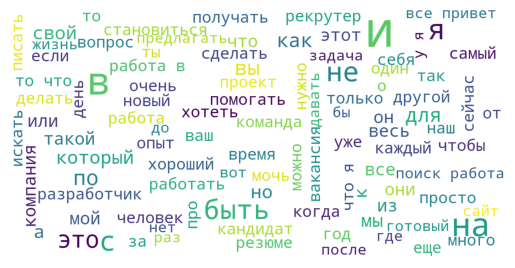

In [135]:
%%time
wordcloud = WordCloud(background_color='white',max_words=100,
                      max_font_size=40,
                      scale=3,
                      random_state=SEED).generate(' '.join(lemmatized_texts))
plt.axis('off')
plt.imshow(wordcloud)

In [136]:
posts_df['post_text_lemma'] = posts_df['post_text_cleaned'].apply(lemmatize)

## Моделирование

Стоп слова

In [137]:
Stop_Words = list(set(stopwords.words('russian')))
Stop_Words.append('это')
#print(stop_words)

In [138]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)

In [139]:
X = tfidf.fit_transform(lemmatized_texts)
X

<794x609 sparse matrix of type '<class 'numpy.float64'>'
	with 16764 stored elements in Compressed Sparse Row format>

In [140]:
text_df = pd.DataFrame.sparse.from_spmatrix(X, columns = tfidf.get_feature_names_out())
text_df

,авито,автоматизация,айти,активно,активный,актуальный,аналитик,английский,архитектура,база,...,человек,честно,число,читать,чувствовать,школа,штат,этап,являться,язык
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.070314,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.180669
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.122488,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.242597,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049255,0.0,0.0,...,0.037520,0.000000,0.060908,0.0,0.0,0.000000,0.0,0.0,0.0,0.096408
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


## LDA

In [141]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

In [142]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(794, 10)

Ключевые слова для полученных тем

In [143]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
пойти, собирать, язык, весь, оставаться, учить, проводить, дом, телегр, спасибо, видео, вс, таки, классный, отдел, подписываться, коллега, сегодня, благодарность, знакомый

 
Тема 2 :
российский, новость, взгляд, важный, случай, профессионал, выходить, дизайн, рассказывать, тестировщик, игра, красивый, хотеть, получать, тест, проходить, следующий, значок, проверка, навык

 
Тема 3 :
начинаться, называть, релокация, обо, слышать, смотреть, переезжать, россия, думать, дорогой, украина, уходить, оказываться, война, потратить, история, действительно, человек, знать, помнить

 
Тема 4 :
дорогой, оффер, лента, признательный, никто, репост, программирование, добро, лайка, вместе, работа, зп, лайк, удаленный, активно, резюме, искать, работать, благодарный, привет

 
Тема 5 :
подробность, данные, особенность, сдавать, данный, отмечать, друг, привет, деньги, видео, команда, почта, документ, основной, база, присылать, интеллект, россия, сообщение, очень

 
Тема 6 :
небольшой, решение, по

Типичные тексты

In [144]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i+1)
    #print(developer_df.iloc[doc_id]["posts"])
    print(all_texts_cleaned[doc_id])
    print("\n")

Тема  1
собеседовался в компанию где есть алгоритмическая секция сегодня предложили пойти к ним джуном я считаю для себя это личным успехом потому что до этого все алгоритмические секции я заваливал а тут без подготовки вс таки преодолел минимальный барьер


Тема  2
я только что получил а значок за навык разработка клиентской стороны кто хочет быть следующим пройдите тест на проверку навыков


Тема  3
миэт снова на связи осенняя подборка фотографий альма матер специально для вас дорогие миэтовцы все помнят на что похож наш университет с высоты птичьего полта


Тема  4
всем привет сейчас я активно ищу работу ранее занимался разработкой на и живу на кипре готов работать удаленно заранее благодарен за любую обратную связь всем добра


Тема  5
в данном видеокурсе мы с вами рассмотрим документно ориентированная база данных используемая для хранения больших объемов информации основная особенность базы это представление данных в виде документов структура которых напоминает благодаря такому по

LDA для постов отдельно

In [145]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)
X = tfidf.fit_transform(posts_df['post_text_lemma'])
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(542, 10)

In [146]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
теплый, нетворкинг, научать, ов, переговоры, критический, деловой, креативный, недавно, присоединяться, подборка, голова, легко, лидерство, сказать, точно, письмо, хотеться, менторский, мышление

 
Тема 2 :
взгляд, менторство, якщо, сво, робот, мена, ви, ми, досвд, робощать, це, вд, що, благодарность, наставничество, як, ваш, отзыв, благодарить, потрясающийнаставник

 
Тема 3 :
лс, получение, продавать, набирать, право, степень, сертификат, обратный, миллион, приятно, менторство, дорогой, яндекс, подготовить, серия, благодарить, пример, лидерство, наставничество, основатель

 
Тема 4 :
наставничество, бизнес, обучение, хотеть, преподавание, весь, мочь, программа, работать, развитие, новый, человек, команда, проект, год, компания, опыт, который, свой, работа

 
Тема 5 :
якщо, команда, справляться, оно, многое, совместный, увидеть, регион, наш, разбирать, канал, телегр, джуна, работа, информация, ко, проектный, деталь, функция, просить

 
Тема 6 :
связывать, сессия, лидерство, з

LDA по объединенным данным

In [147]:
posts_df[posts_df['post_text_lemma']==None]['post_text_lemma'].count()

0

In [148]:
concatenated_texts = pd.concat([posts_df['post_text_lemma'], pd.Series(lemmatized_texts)])
concatenated_texts

0      в компания искать второй дизайнер который гото...
1      продолжение открытый менторский сессия тимлиды...
2      чудесный новина съосноватеть на спечель наград...
3      стажування менторство розробка програмування к...
4                                                       
                             ...                        
789       начинать работа в новый должность в компания\n
790    самый распространенный ошибка в резюмеребенок ...
791         все привет на это все не забывать лайкнуть\n
792                   а вы переживать за свой кандидат\n
793    компания вынуждать внедрять политика удаленный...
Length: 1336, dtype: object

In [149]:
tfidf = TfidfVectorizer(stop_words=Stop_Words, min_df=10, max_df=0.9)
X = tfidf.fit_transform(concatenated_texts)
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
topics = lda.fit_transform(X)
topics.shape

(1336, 10)

In [150]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
оценивать, пойти, нанимать, попадать, слово, главное, успевать, близкий, спрашивать, уходить, переходить, недавно, добрый, спасибо, джуна, добавлять, второй, работа, резюме, просить

 
Тема 2 :
ви, мена, александр, менторство, мож, робот, досвд, робощать, це, ми, вд, ще, що, благодарность, як, наставничество, ваш, благодарить, отзыв, потрясающийнаставник

 
Тема 3 :
тестирование, факт, вакансия, управление, искусство, решение, тестировщик, когнитивный, критический, место, разработчик, сегодня, мышление, работа, компания, новый, начинать, должность, удовольствие, сообщать

 
Тема 4 :
навык, помогать, наш, время, мочь, вакансия, новый, очень, хотеть, работать, весь, человек, команда, проект, компания, опыт, год, который, свой, работа

 
Тема 5 :
сертификат, конференция, мир, оффлайн, турция, интеграция, релокация, конец, банковский, рейтинг, получать, глубокий, топовый, мужчина, любимый, товарищ, безопасность, перевод, реализовывать, дата

 
Тема 6 :
счастливый, взгляд, поскольк